<a href="https://colab.research.google.com/github/simply-sankalp/GHI-forecast/blob/main/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-23058558.py:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill').fillna(method='bfill')



 🔍 TIME SERIES PATTERN SUMMARY

ADF Test p-value: 0.0000
Trend Strength: 49.3654
Seasonal Strength: 304.0714

Detected Pattern:
 - Trend Present
 - Seasonality Present (daily)
 - Stationary Series

Overall Classification: Trend + Seasonality


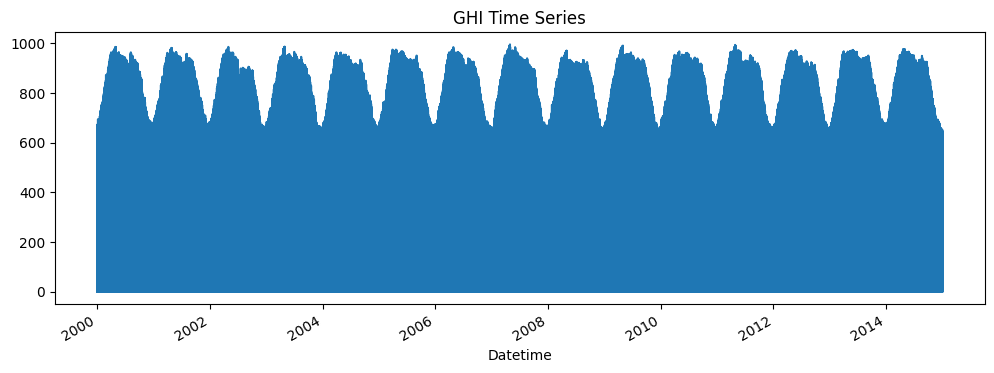

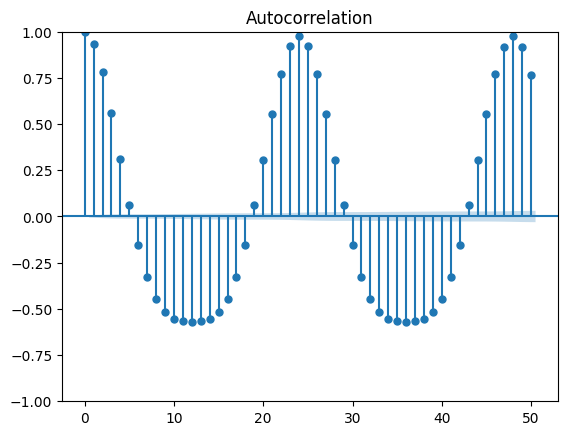

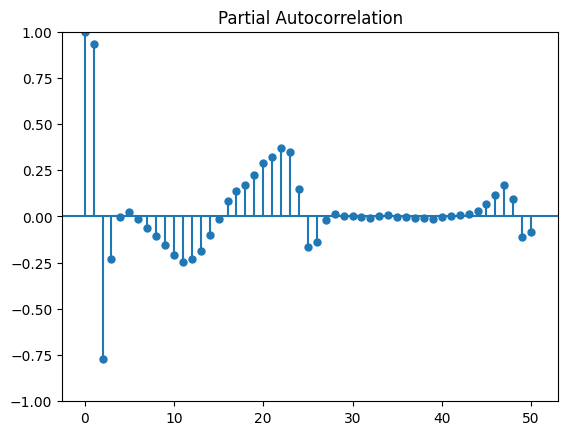

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# ---------------------------------------------------------
# 1. LOAD ALL CSV FILES
# ---------------------------------------------------------
path = "./data/*.csv"          # <-- change this to your folder path
files = glob.glob(path)

dfs = []

for f in files:
    df = pd.read_csv(f, skiprows=2)  # skip metadata rows
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# ---------------------------------------------------------
# 2. CLEAN & CREATE DATETIME INDEX
# ---------------------------------------------------------
data['Datetime'] = pd.to_datetime(
    data[['Year', 'Month', 'Day', 'Hour', 'Minute']]
)

data = data.set_index('Datetime')

# Choose the column you want to analyze (example: GHI)
ts = data['GHI'].astype(float)

# Remove missing or weird values
ts = ts.replace("N/A", np.nan).astype(float)
ts = ts.fillna(method='ffill').fillna(method='bfill')

# ---------------------------------------------------------
# 3. STATIONARITY TEST (ADF)
# ---------------------------------------------------------
def adf_test(x):
    result = adfuller(x.dropna())
    return result[1]   # p-value

adf_pvalue = adf_test(ts)

# ---------------------------------------------------------
# 4. CHECK SEASONALITY USING STL DECOMPOSITION
# ---------------------------------------------------------
decomposition = seasonal_decompose(ts, model='additive', period=24)
seasonal_strength = decomposition.seasonal.std()
trend_strength = decomposition.trend.std()

# ---------------------------------------------------------
# 5. DETERMINE DATA PATTERN
# ---------------------------------------------------------
pattern = []

# Trend check
if trend_strength > 0.1 * ts.std():
    pattern.append("Trend Present")
else:
    pattern.append("No Significant Trend")

# Seasonality check
if seasonal_strength > 0.1 * ts.std():
    pattern.append("Seasonality Present (daily)")
else:
    pattern.append("No Significant Seasonality")

# Stationarity check (ADF)
if adf_pvalue < 0.05:
    pattern.append("Stationary Series")
else:
    pattern.append("Non-Stationary Series")

# ---------------------------------------------------------
# 6. PRINT RESULT SUMMARY
# ---------------------------------------------------------
print("\n===============================")
print(" 🔍 TIME SERIES PATTERN SUMMARY")
print("===============================\n")

print(f"ADF Test p-value: {adf_pvalue:.4f}")
print(f"Trend Strength: {trend_strength:.4f}")
print(f"Seasonal Strength: {seasonal_strength:.4f}")

print("\nDetected Pattern:")
for p in pattern:
    print(" -", p)

# Final classification
print("\nOverall Classification:", end=" ")

if "Trend Present" in pattern and "Seasonality Present (daily)" in pattern:
    print("Trend + Seasonality")
elif "Trend Present" in pattern:
    print("Trend Only")
elif "Seasonality Present (daily)" in pattern:
    print("Seasonality Only")
else:
    print("No Trend / No Seasonality")

# ---------------------------------------------------------
# 7. OPTIONAL: PLOTS
# ---------------------------------------------------------
ts.plot(figsize=(12, 4), title="GHI Time Series")
plt.show()

plot_acf(ts.dropna(), lags=50)
plt.show()

plot_pacf(ts.dropna(), lags=50)
plt.show()
